In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn import linear_model
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt

import librosa as lr
from glob import glob

## Introducing the dataset

### As mentioned in the video, you'll deal with stock market prices that fluctuate over time. In this exercise you've got historical prices from two tech companies (Ebay and Yahoo) in the DataFrame prices. You'll visualize the raw data for the two companies, then generate a scatter plot showing how the values for each company compare with one another. Finally, you'll add in a "time" dimension to your scatter plot so you can see how this relationship changes over time.

### The data has been loaded into a DataFrame called prices.

### Instructions 1/3
-    Plot the data in prices. Pay attention to any irregularities you notice.

In [2]:
df = pd.read_csv("data/prices.csv")
df = df.sort_index()
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

prices = df[df["symbol"].isin(["EBAY", "YHOO"])].pivot(columns="symbol", values="close", index="date")

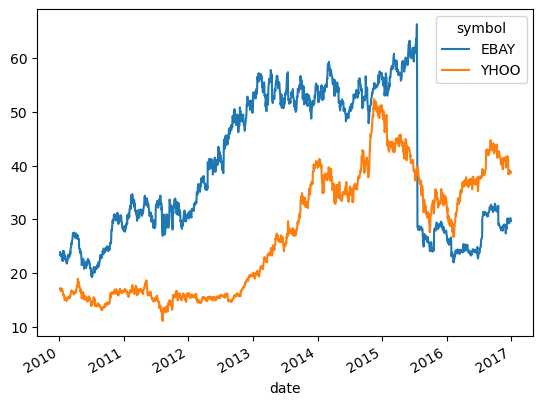

In [3]:
# Plot the raw values over time
prices.plot()
plt.show()

### Instructions 2/3
-    Generate a scatter plot with the values of Ebay on the x-axis, and Yahoo on the y-axis. Look up the symbols for both companies from the column names of the DataFrame.

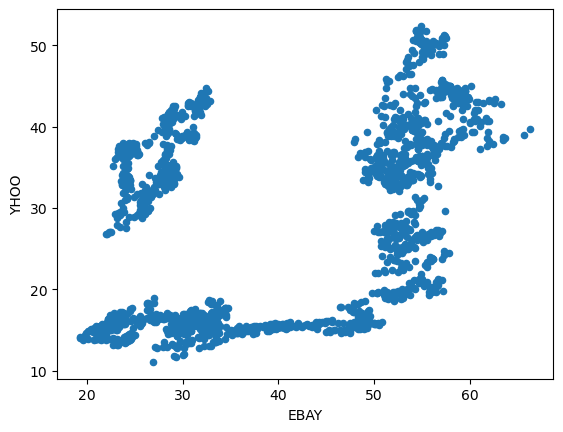

In [4]:
# Scatterplot with one company per axis
prices.plot.scatter("EBAY", "YHOO")
plt.show()

### Instructions 3/3
-    Finally, encode time as the color of each datapoint in order to visualize how the relationship between these two variables changes.

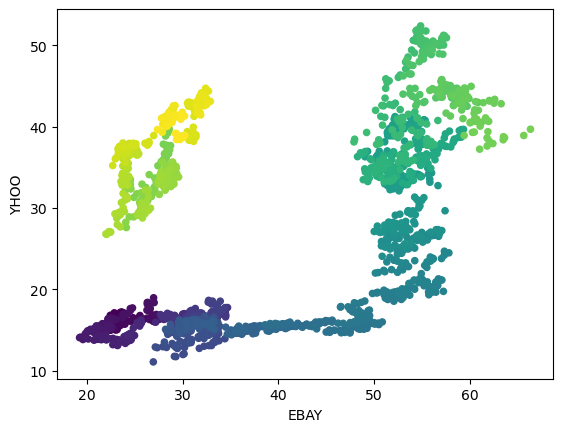

In [5]:
# Scatterplot with color relating to time
prices.plot.scatter('EBAY', 'YHOO', c=prices.index, 
                    cmap=plt.cm.viridis, colorbar=False)
plt.show()

## Fitting a simple regression model

### Now we'll look at a larger number of companies. Recall that we have historical price values for many companies. Let's use data from several companies to predict the value of a test company. You'll attempt to predict the value of the Apple stock price using the values of NVidia, Ebay, and Yahoo. Each of these is stored as a column in the all_prices DataFrame. Below is a mapping from company name to column name:

-    ebay: "EBAY"
-    nvidia: "NVDA"
-    yahoo: "YHOO"
-    apple: "AAPL"

### We'll use these columns to define the input/output arrays in our model.

### Instructions
-    Create the X and y arrays by using the column names provided.
-    The input values should be from the companies "ebay", "nvidia", and "yahoo"
-    The output values should be from the company "apple"
-    Use the data to train and score the model with cross-validation.

In [6]:
all_prices = df[df["symbol"].isin(["EBAY", "NVDA", "YHOO", "AAPL"])].pivot(columns="symbol", values="close", index="date")

In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Use stock symbols to extract training data
X = all_prices[["EBAY", "NVDA", "YHOO"]]
y = all_prices[["AAPL"]]

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[  -0.55495235   -0.9912733  -322.41700994]


## Visualizing predicted values

### When dealing with time series data, it's useful to visualize model predictions on top of the "actual" values that are used to test the model.

### In this exercise, after splitting the data (stored in the variables X and y) into training and test sets, you'll build a model and then visualize the model's predictions on top of the testing data in order to estimate the model's performance.

### Instructions 1/2
-    Split the data (X and y) into training and test sets.
-    Use the training data to train the regression model.
-    Then use the testing data to generate predictions for the model.

In [8]:
## If you include the whole data-set you get a insane score, they filtered it down to 775 datapoints, not sure how they arrived at that
X = all_prices[["EBAY", "NVDA", "YHOO"]][:775].values
y = all_prices["AAPL"][:775].values

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=False)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

-5.709399019485156


### Instructions 2/2
-    Plot a time series of the predicted and "actual" values of the testing data.

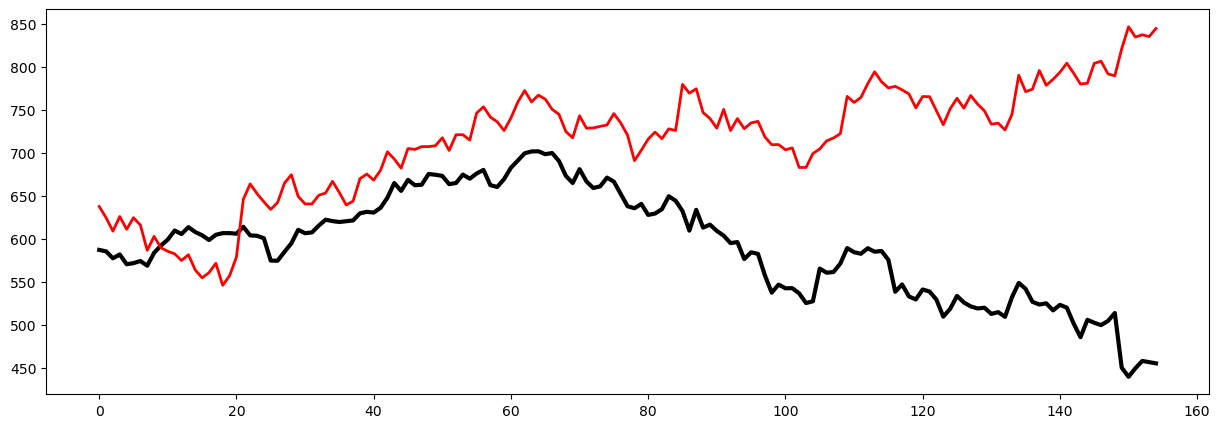

In [10]:
# Visualize our predictions along with the "true" values, and print the score
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
plt.show()

## Visualizing messy data
### Let's take a look at a new dataset - this one is a bit less-clean than what you've seen before.

### As always, you'll first start by visualizing the raw data. Take a close look and try to find datapoints that could be problematic for fitting models.

### The data has been loaded into a DataFrame called prices.

### Instructions
-    Visualize the time series data using Pandas.
-    Calculate the number of missing values in each time series. Note any irregularities that you can see. What do you think they are?

In [11]:
prices = df[df["symbol"].isin(["EBAY", "NVDA", "YHOO"])].pivot(columns="symbol", values="close", index="date")

# They made some of the data to disappear from their data set, so we need to eliminate them
prices.loc["2013-01-01":"2014-01-01", "EBAY"] = np.nan
prices.loc["2011-06-01":"2012-04-01", "YHOO"] = np.nan
prices.loc["2011-01-01":"2013-01-01", "NVDA"] = np.nan

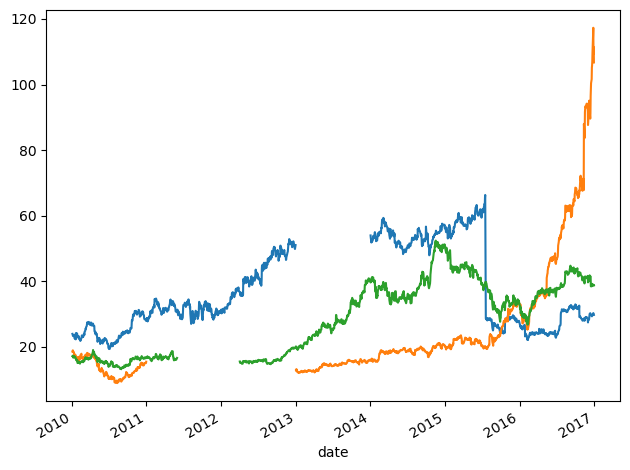

symbol
EBAY    252
NVDA    502
YHOO    211
dtype: int64


In [12]:
# Visualize the dataset
prices.plot(legend=False)
plt.tight_layout()
plt.show()

# Count the missing values of each time series
missing_values = prices.isna().sum()
print(missing_values)

## Imputing missing values
### When you have missing data points, how can you fill them in?

### In this exercise, you'll practice using different interpolation methods to fill in some missing values, visualizing the result each time. But first, you will create the function (interpolate_and_plot()) you'll use to interpolate missing data points and plot them.

### A single time series has been loaded into a DataFrame called prices.

### Instructions 1/4
-    Create a boolean mask for missing values and interpolate the missing values using the interpolation argument of the function.

In [13]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

### Instructions 2/4
-    Interpolate using the latest non-missing value and plot the results.  Recall that interpolate_and_plot's second input is a string specifying the kind of interpolation to use.

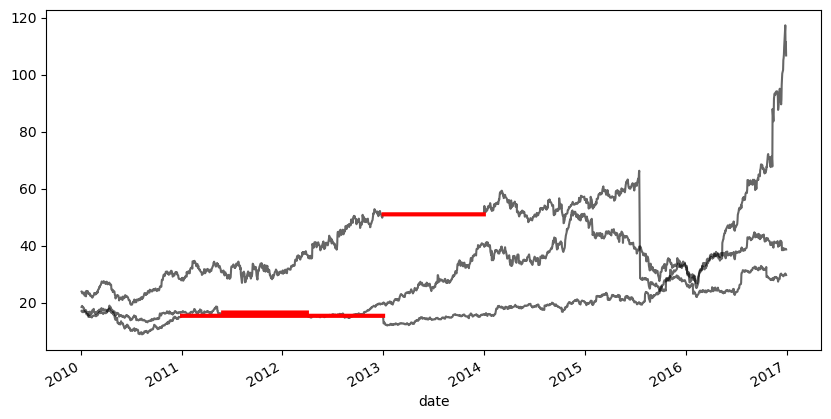

In [14]:
# Interpolate using the latest non-missing value
interpolation_type = 'zero'
interpolate_and_plot(prices, interpolation_type)

### Instructions 3/4
-    Interpolate linearly and plot the results.

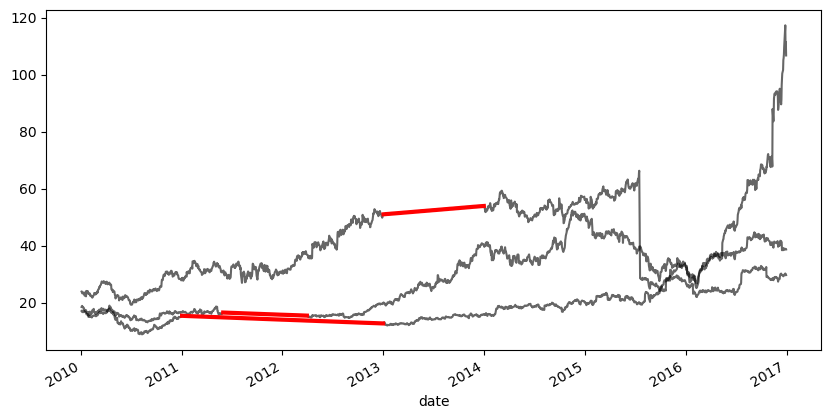

In [15]:
# Interpolate linearly
interpolation_type = "linear"
interpolate_and_plot(prices, interpolation_type)

### Instructions 4/4
-    Interpolate with a quadratic function and plot the results.

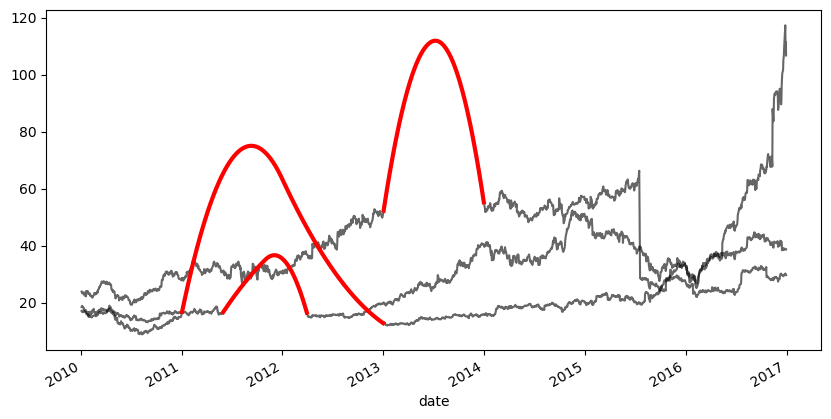

In [16]:
# Interpolate with a quadratic function
interpolation_type = "quadratic"
interpolate_and_plot(prices, interpolation_type)

## Transforming raw data
### In the last chapter, you calculated the rolling mean. In this exercise, you will define a function that calculates the percent change of the latest data point from the mean of a window of previous data points. This function will help you calculate the percent change over a rolling window.

### This is a more stable kind of time series that is often useful in machine learning.

### Instructions
-    Define a percent_change function that takes an input time series and does the following:
-    Extract all but the last value of the input series (assigned to previous_values) and the only the last value of the timeseries ( assigned to last_value)
-    Calculate the percentage difference between the last value and the mean of earlier values.
-    Using a rolling window of 20, apply this function to prices, and visualize it using the given code.

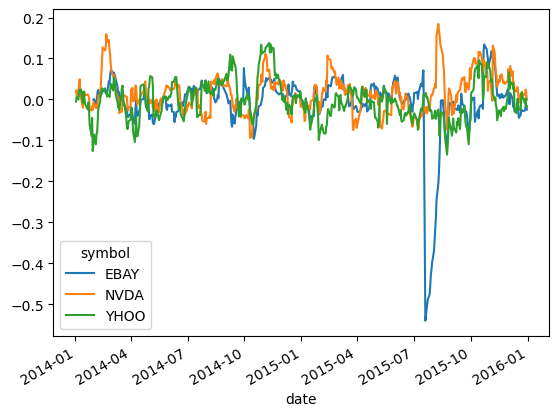

In [17]:
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

## Handling outliers
### In this exercise, you'll handle outliers - data points that are so different from the rest of your data, that you treat them differently from other "normal-looking" data points. You'll use the output from the previous exercise (percent change over time) to detect the outliers. First you will write a function that replaces outlier data points with the median value from the entire time series.

### Instructions
-    Define a function that takes an input series and does the following:
-    Calculates the absolute value of each datapoint's distance from the series mean, then creates a boolean mask for datapoints that are three times the standard deviation from the mean.
-    Use this boolean mask to replace the outliers with the median of the entire series.
-    Apply this function to your data and visualize the results using the given code.

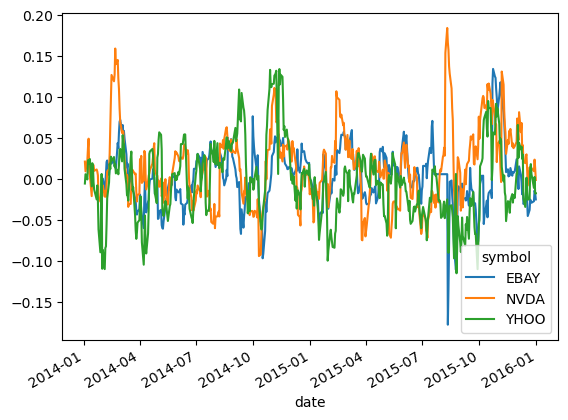

In [18]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()

## Engineering multiple rolling features at once
### Now that you've practiced some simple feature engineering, let's move on to something more complex. You'll calculate a collection of features for your time series data and visualize what they look like over time. This process resembles how many other time series models operate.

### Instructions
-    Define a list consisting of four features you will calculate: the minimum, maximum, mean, and standard deviation (in that order).
-    Using the rolling window (prices_perc_rolling) we defined for you, calculate the features from features_to_calculate.
-    Plot the results over time, along with the original time series using the given code.

In [19]:
prices_perc_old = prices_perc
prices_perc = prices_perc_old['EBAY']

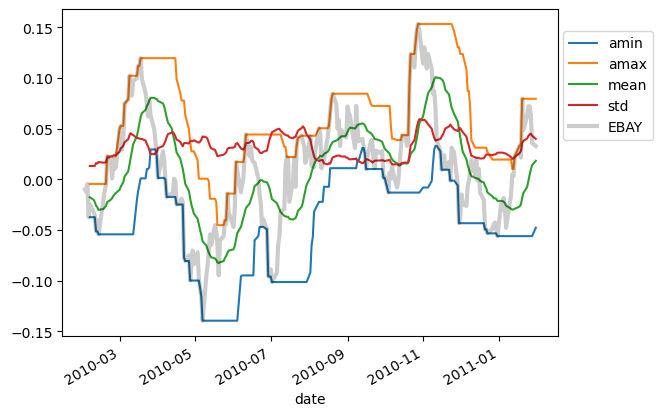

In [20]:
# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

## Percentiles and partial functions
### In this exercise, you'll practice how to pre-choose arguments of a function so that you can pre-configure how it runs. You'll use this to calculate several percentiles of your data using the same percentile() function in numpy.

### Instructions
-    Import partial from functools.
-    Use the partial() function to create several feature generators that calculate percentiles of your data using a list comprehension.
-    Using the rolling window (prices_perc_rolling) we defined for you, calculate the quantiles using percentile_functions.
-    Visualize the results using the code given to you.

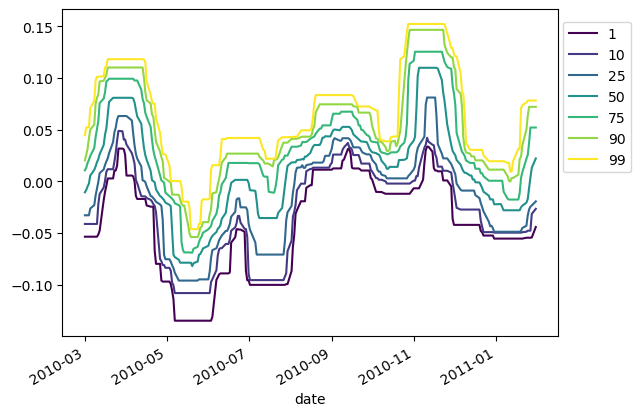

In [21]:
# Import partial from functools
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

## Using "date" information
### It's easy to think of timestamps as pure numbers, but don't forget they generally correspond to things that happen in the real world. That means there's often extra information encoded in the data such as "is it a weekday?" or "is it a holiday?". This information is often useful in predicting timeseries data.

### In this exercise, you'll extract these date/time based features. A single time series has been loaded in a variable called prices.

### Instructions
-    Calculate the day of the week, week number in a year, and month number in a year.
-    Add each one as a column to the prices_perc DataFrame, under the names day_of_week, week_of_year and month_of_year, respectively.

In [40]:
prices_perc = pd.DataFrame({ "EBAY": prices_perc_old["EBAY"].values }, index=prices_perc_old.index.values)

In [42]:
# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.weekday
#prices_perc['week_of_year'] = prices_perc.index.week ## THIS DOESN'T WORK ANYMORE (OR AT LEAST NOT IN MY VERSION)
prices_perc['week_of_year'] = prices_perc.index.isocalendar().week
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
print(prices_perc)

                EBAY  day_of_week  week_of_year  month_of_year
2010-01-04       NaN            0             1              1
2010-01-05       NaN            1             1              1
2010-01-06       NaN            2             1              1
2010-01-07       NaN            3             1              1
2010-01-08       NaN            4             1              1
...              ...          ...           ...            ...
2016-12-23  0.024842            4            51             12
2016-12-27  0.038030            1            52             12
2016-12-28  0.026925            2            52             12
2016-12-29  0.021850            3            52             12
2016-12-30  0.007285            4            52             12

[1762 rows x 4 columns]
